In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from pprint import pprint
import random
import matplotlib.pyplot as plt
from random import randrange
import seaborn as sns

In [236]:
dataset=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])

# Decison Tree

In [237]:
def datasetFunc1(data): #reading data for classification problem
    data_new=pd.DataFrame()
    data = data.drop("No", axis=1)
    data = data.rename(columns={"month": "label"})
    data_new['label']=data['label']
    data=data.drop('label', axis=1)
    print("Data Shape:",data.shape)
    data['label']=data_new['label']
    data=data.fillna(data.mean())
    train_dataframe=data.loc[data['year'].isin(['2010','2012'])]
    test_dataframe=data.loc[data['year'].isin(['2011','2013'])]
    print("Training shape:",train_dataframe.shape)
    print("Testing shape:",test_dataframe.shape)
    return train_dataframe,test_dataframe

In [238]:
def datasetFunc2(data):#reading data for regression problem
    data_new=pd.DataFrame()
    data = data.drop("No", axis=1)
    data = data.rename(columns={"pm2.5": "label"})
    data_new['label']=data['label']
    data=data.drop('label', axis=1)
    data['label']=data_new['label']
    data=data.fillna(data.mean())
    train_dataframe=data.loc[data['year'].isin(['2010','2012'])]
    test_dataframe=data.loc[data['year'].isin(['2011','2013'])]
    print("Training shape:",train_dataframe.shape)
    print("Testing shape:",test_dataframe.shape)
    return train_dataframe,test_dataframe

In [239]:
def featureType(data): # distingusihing if column is catergorial or continuos
    types = []
    threshold_unique_values = 15
    for col in data.columns:
        if col!="label":
            values = data[col].unique()
            temp=values[0]
            if (isinstance(temp,str)) or (len(values)<=threshold_unique_values):
                types.append("categorical")
            else:
                types.append("continuous")
    return types

In [240]:
def bestSplit(data,splitting_points,job): #trying to get the nest split by iterating over values in each column
    first_iteration = True
    for col in splitting_points:
        for val in splitting_points[col]:
            data_left,data_right = dataSplitting(data,col,val,types[col])
            if job == "classification":
                result=totalScore(data_left,data_right,score_fun=gini)
            elif job=='regression':
                result=totalScore(data_left,data_right,score_fun=rss)
            if first_iteration or result<=max_:
                first_iteration=False   
                max_=result
                split_col=col
                split_value=val
    return split_col,split_value

In [241]:
def decisionTree(data,job,flag,min_samples,max_depth,feature_subset): #main algorithm
    if flag==0:  #min_samples resent the min no of data points to make a split and max_depth teh max depth the tree can go through
        global cols,types
        types,cols=helper2(data)
        data=data.values   
    if (purityCheck(data)) or (flag==max_depth) or (len(data)<min_samples): #chceking for the prunning steps
        label=labelling(data,job)
        return label
    else:    
        splitting_points=splitPoints(data,feature_subset)
        split_col,split_value=bestSplit(data,splitting_points,job)
        data_left,data_right=dataSplitting(data,split_col,split_value,types[split_col])
        if len(data_left)==0 or len(data_right) == 0: # chceking if any node is empty, is yes atsrt labelling
            label=labelling(data,job)
            return label 
        feature_type=types[split_col]
        feature=cols[split_col]
        if feature_type=="categorical":
            query="{} = {}".format(feature,split_value)
        elif feature_type=="continuous":
            query="{} <= {}".format(feature,split_value) 
        flag+= 1
        tree={query:[]}
        left_1=decisionTree(data_left,job,flag,min_samples,max_depth,feature_subset) #recursive call for algo
        right_0=decisionTree(data_right,job,flag,min_samples,max_depth,feature_subset)
        if left_1 != right_0: #if max_depth are reached and both left and right child has same class we just merge
            tree[query].append(left_1)
            tree[query].append(right_0)
        else:
            tree = left_1
        return tree

In [437]:
def splitPoints(data,feature_subset): #getting the list of point across whihc one should split
    splitting_points={}
    no_rows,no_columns = data.shape
    indexes= list(range(no_columns-1))
    if feature_subset and feature_subset <= len(indexes):
        indexes=random.sample(population=indexes,k=feature_subset )
    for col in indexes:
        splitting_points[col]=[]
        splitting_points[col]=np.unique(data[:, col])
    return splitting_points

In [243]:
def purityCheck(data): #chceking the purity of the node
    classes=np.unique(data[:, -1]) #getting the unique classes for the data
    if len(classes)==1: #chceking purity
        return True
    else:
        return False

In [244]:
def dataSplitting(data,split_col,split_value,feature_type): #spliting the node based on best split point
    values=data[:, split_col]
    if feature_type=="categorical":
        data_left=data[values==split_value]
        data_right=data[values!=split_value] 
    elif feature_type=="continuous":
        data_left=data[values<=split_value]
        data_right=data[values>split_value] 
    return data_left, data_right

In [245]:
def gini(data): #caluulating ginin index for a node
    labels=data[:, -1]
    classes,counts=np.unique(labels,return_counts=True)
    prob=counts/counts.sum()
    gini=sum(prob*(1-prob))
    return gini

In [246]:
def rss(data): #calcuting rss for a node
    values=data[:, -1]
    if len(values)== 0:
        rss= 0  
    else:
        predicted=np.mean(values)
        rss=sum((values-predicted)**2)
    return rss

In [247]:
def labelling(data,job): # getting the predicted label
    labels=data[:, -1]
    if job=="classification":
        classes,count_classes=np.unique(labels, return_counts=True)
        index=count_classes.argmax()
        label=classes[index]       
    elif job=="regression":
        label=np.mean(labels)      
    return label

In [248]:
def predicting(test,tree):
    query=list(tree.keys())[0] # getting the query at a node
    feature,operator,value=query.split(" ")
    if operator=="<=":
        if test[feature]<=float(value):
            ans=tree[query][0]
        else:
            ans=tree[query][1]
    else:
        if str(test[feature])==value: #categorial chceking for value
            ans=tree[query][0]
        else:
            ans=tree[query][1]
    if not isinstance(ans, dict): #checking  if the node is pure or not
        return ans
    else:
        tree=ans
        return predicting(test, tree)

In [249]:
def totalScore(data_left,data_right,score_fun): #overall ginin or rss calaultion
    total=len(data_left)+len(data_right)
    prob_left=len(data_left)/total
    prob_right= len(data_right)/total
    weighted_score=(prob_left*score_fun(data_left)+prob_right*score_fun(data_right))
    return weighted_score

In [250]:
def helper2(data):
    cols=data.columns
    types=featureType(data)
    return types,cols

In [251]:
def accuracyFunc(data,tree):
    actual=data.label
    predicted = data.apply(predicting,args=(tree,),axis=1)
    temp=[actual.iloc[i]==predicted.iloc[i] for i in range(len(actual)) ]
    accuarcy=np.mean(temp)
    return accuarcy

In [380]:
def mseFunc(data,tree):    
    actual=data.label
    predicted = data.apply(predicting,args=(tree,),axis=1)
    temp=[abs(actual.iloc[i]-predicted.iloc[i]) for i in range(len(actual)) ]
    mse=np.mean(np.square(temp))
    mean_=np.mean(temp)
    std_=np.std(temp)
    return mse,mean_,std_

# Simple Classification

In [374]:
job='classification'
flag=0
min_samples=5
max_depth=5
feature_subset=None
train_dataframe_class,test_dataframe_class=datasetFunc1(dataset)
tree_class=decisionTree(train_dataframe_class,job,flag,min_samples,max_depth,feature_subset)
accuracy=accuracyFunc(test_dataframe_class,tree_class)
print("Accuarcy:",accuracy)

Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
Accuarcy: 0.38801369863013696


In [375]:
#Analysis for classification
#max_depth=5 and min_samples 5 , I am getting the best accuarcy
train_dataframe_class,test_dataframe_class=datasetFunc1(dataset)
maxdepth=[]
minsamples=[]
acc=[]
job='classification'
flag=0
feature_subset=None
for max_depth in range(3, 8):
    print("Completed iteration:",max_depth)
    for min_samples in range(3,10,3):
        tree_class=decisionTree(train_dataframe_class,job,flag,min_samples,max_depth,feature_subset) 
        accuracy=accuracyFunc(test_dataframe_class,tree_class)
        maxdepth.append(max_depth)
        minsamples.append(min_samples)
        acc.append(accuracy)
analysis= pd.DataFrame()
analysis['max_depth']=maxdepth
analysis['min_samples']=minsamples
analysis['accuracy']=acc
analysis.sort_values("accuracy", ascending=False).head()

Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
Completed iteration: 3
Completed iteration: 4
Completed iteration: 5
Completed iteration: 6
Completed iteration: 7


max_depth  min_samples  accuracy
6           5            3  0.388014
7           5            6  0.388014
8           5            9  0.388014
12          7            3  0.387614
13          7            6  0.387614

# Simple Regression

In [381]:
job='regression'
flag=0
min_samples=15
max_depth=6
feature_subset=None
train_dataframe_reg,test_dataframe_reg=datasetFunc2(dataset)
tree_reg=decisionTree(train_dataframe_reg,job,flag,min_samples,max_depth,feature_subset)
mse,mean_,std_= mseFunc(test_dataframe_reg,tree_reg)
print("MSE:",mse)
print("mean:",mean_)
print("standard deviation:",std_)

Training shape: (17544, 12)
Testing shape: (17520, 12)
MSE: 6537.43383469871
mean: 57.0724420802871
standard deviation: 57.27277005428484


In [384]:
#Analaysis for regression
train_dataframe_reg,test_dataframe_reg=datasetFunc2(dataset)
maxdepth=[]
minsamples=[]
mse_list=[]
mean_list=[]
std_list=[]
job='regression'
flag=0
feature_subset=None
for max_depth in range(3, 8):
    print("Completed iteration:",max_depth)
    for min_samples in range(3,10,3):
        tree_reg=decisionTree(train_dataframe_reg,job,flag,min_samples,max_depth,feature_subset) 
        mse,mean_,std_= mseFunc(test_dataframe_reg,tree_reg)
        maxdepth.append(max_depth)
        minsamples.append(min_samples)
        mse_list.append(mse)
        mean_list.append(mean_)
        std_list.append(std_)
analysis= pd.DataFrame()
analysis['max_depth']=maxdepth
analysis['min_samples']=minsamples
analysis['mse']=mse_list
analysis['mean']=mean_list
analysis['std']=std_list
analysis.sort_values("mse", ascending=True).head()

Training shape: (17544, 12)
Testing shape: (17520, 12)
Completed iteration: 3
Completed iteration: 4
Completed iteration: 5
Completed iteration: 6
Completed iteration: 7


max_depth  min_samples          mse       mean        std
9           6            3  6537.433835  57.072442  57.272770
10          6            6  6537.433835  57.072442  57.272770
11          6            9  6537.433835  57.072442  57.272770
6           5            3  6705.337884  57.985346  57.819007
7           5            6  6705.337884  57.985346  57.819007

# Bagged DT

In [198]:
def mseBagFunc(actual,predicted):  
    temp=[actual[i]-predicted[i] for i in range(len(actual)) ]
    mse=np.mean(np.square(temp))
    mean_=np.mean(temp)
    std_=np.std(temp)
    return mse,mean_,std_

In [205]:
def accuracyBagFunc(actual,predicted):
    correct=0
    for i in range(len(actual)):
        if actual[i]==predicted[i]:
            correct+=1
    return correct/float(len(actual))

In [203]:
def helper1(data,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset):
    scores=list()
    if(job=="classification"):
        train_dataframe,test_dataframe=datasetFunc1(data)
    elif(job=="regression"):
        train_dataframe,test_dataframe=datasetFunc2(data)
    predicted=baggingFunc(train_dataframe,test_dataframe,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset).tolist()
    actual=test_dataframe["label"].tolist()
    if job=="classification":
        accuracy = accuracyBagFunc(actual,predicted)
        return accuracy
    elif job=="regression":
        mse,mean_,std_=mseBagFunc(actual, predicted)
        return mse,mean_,std_

In [432]:
def sampling(data,subset_size):
    subset=data.sample(frac =subset_size,replace = True) 
    return subset

In [191]:
def bagPredicting(row,trees,job):
    predicted=[predicting(row, tree) for tree in trees]
    if job=="classification":
        return max(set(predicted), key=predicted.count)
    elif job=="regression":
        return np.mean(predicted)

In [207]:
def baggingFunc(train,test,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset):
    trees = list()
    for i in range(no_trees):
        subset=sampling(train,subset_size)
        tree=decisionTree(subset,job,flag,max_depth,min_samples,feature_subset)
        trees.append(tree)
    predicted=list()
    predicted = test.apply(bagPredicting,args=(trees,job,),axis=1)
    return(predicted)

# Bagged Regression

In [419]:
subset_size = 1
job="regression"
max_depth = 6
min_samples = 3
flag=0
feature_subset=0
no_tree_list=[]
mse_list=[]
mean_list=[]
std_list=[]
for no_trees in [1,5,10]:
        mse,mean_,std_= helper1(dataset,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset)
        print('At no of tree',no_trees)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
        no_tree_list.append(no_trees)
        mse_list.append(mse)
        mean_list.append(mean_)
        std_list.append(std_)
        
analysis= pd.DataFrame()
analysis['no_trees']=no_tree_list
analysis['mse']=mse_list
analysis['mean']=mean_list
analysis['std']=std_list
analysis.sort_values("mse", ascending=True).head()

Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 1
MSE: 7347.799745102255
mean: -4.429127591945803
standard deviation: 85.60480461911305
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 5
MSE: 7184.542683629629
mean: -3.809182892907487
standard deviation: 84.67604625464045
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 10
MSE: 7219.91174858274
mean: -3.3491050413528067
standard deviation: 84.90403549893682


no_trees          mse      mean        std
1         5  7184.542684 -3.809183  84.676046
2        10  7219.911749 -3.349105  84.904035
0         1  7347.799745 -4.429128  85.604805

# Bagged Classification

In [ ]:
subset_size = 1
job="classification"
max_depth = 5
min_samples = 3
flag=0
no_tree_list=[]
acc=[]
feature_subset=0
for no_trees in [5,10,15]:
        accuarcy = helper1(dataset,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset)
        print('At no of tree',no_trees)
        print('Accuarcy:',accuarcy)
        no_tree_list.append(no_trees)
        acc.append(accuarcy)
        
analysis= pd.DataFrame()
analysis['no_trees']=no_tree_list
analysis['acc']=acc
analysis.sort_values("acc", ascending=False)

Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 5
Accuarcy: 0.33259132420091325
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 10
Accuarcy: 0.3230022831050228
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)


# Random Forest Classification

In [422]:
subset_size = 0.60
job="classification"
max_depth = 5
min_samples = 3
flag=0
no_tree_list=[]
acc=[]
no_feature=[]
for no_trees in [1,5,10]:
    for feature_subset in [3,12,3]:
            accuracy = helper1(dataset,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset)
            print('At no of tree',no_trees)
            print('Accuarcy:',accuracy)
            no_tree_list.append(no_trees)
            acc.append(accuarcy)
            no_feature.append(feature_subset)

analysis= pd.DataFrame()
analysis['no_trees']=no_tree_list
analysis['acc']=acc
analysis['no_feature']=no_feature
analysis.sort_values("acc", ascending=False).head()

Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 1
Accuarcy: 0.33373287671232876
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
At no of tree 1
Accuarcy: 0.3379566210045662
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)


KeyboardInterrupt: 

#  Random Forest Regression

In [ ]:
subset_size = 0.60
job="regression"
max_depth = 6
min_samples = 3
flag=0
no_tree_list=[]
mse_list=[]
mean_list=[]
std_list=[]
no_features=[]
for no_trees in [1,5,10]:
    for feature_subset in [3,12,3]:
        mse,mean_,std_= helper1(dataset,job,flag,max_depth,min_samples,subset_size,no_trees,feature_subset)
        print('At no of tree',no_trees)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
        no_tree_list.append(no_trees)
        mse_list.append(mse)
        mean_list.append(mean_)
        std_list.append(std_)
        no_features.append(feature_subset)
        
        
analysis= pd.DataFrame()
analysis['no_trees']=no_tree_list
analysis['mse']=mse_list
analysis['mean']=mean_list
analysis['std']=std_list
analysis['no_features']=no_features
analysis.sort_values("mse", ascending=True).head()

# Gaussian Processes Regression

In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C  
from sklearn.linear_model import LinearRegression

In [3]:
dataset=pd.read_csv("GP.csv",header=[0])
dataset = dataset.drop("Sr.No", axis=1)
dataset = dataset.rename(columns={"Signal Strength(DBM)": "label"})
print("Data Shape:",dataset.shape)

test_dataframe=dataset.loc[dataset['Distance'].isin([1,3,5,7,9])]
train_dataframe=dataset.loc[dataset['Distance'].isin([0,2,4,6,8,10,11])]
X=np.array(train_dataframe['Distance'])
y=np.array(train_dataframe['label'])
X_test=np.array(test_dataframe['Distance'])
y_test=np.array(test_dataframe['label'])
X = np.atleast_2d(X).T
X_test = np.atleast_2d(X_test).T
print("Train points",X)
print("Value at Train points",y)

Data Shape: (12, 2)
Train points [[ 0]
 [ 2]
 [ 4]
 [ 6]
 [ 8]
 [10]
 [11]]
Value at Train points [-45 -58 -36 -59 -36 -55 -64]


In [4]:
print("Train points",X_test)

Train points [[1]
 [3]
 [5]
 [7]
 [9]]


In [5]:
temp=np.var(y)

In [6]:
print(temp)

111.6734693877551


In [7]:
#kernel = C(1, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
#kernel=C(111.67, (111, 1111)) * RBF(1,(1,1))
gp = GaussianProcessRegressor(n_restarts_optimizer=6,normalize_y=True)
gp.fit(X, y)
print(gp)
print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=6, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
GPML kernel: 1**2 * RBF(length_scale=1)
Log-marginal-likelihood: -463.421


In [15]:
mean,sigma=gp.predict(X_test,return_std=True)
print("Test Points:",X_test.tolist())
print("mean value at Test points",mean)
print("Variance at Test point predictions ",sigma)

Test Points: [[1], [3], [5], [7], [9]]
mean value at Test points [-52.655572   -46.38560746 -47.6162076  -48.45216997 -41.38449265]
Variance at Test point predictions  [0.58994625 0.58670051 0.5866164  0.58529409 0.53664777]


In [11]:
mse=mean_squared_error(y_test, mean)
print("MSE:",mse)

MSE: 96.83003127293676


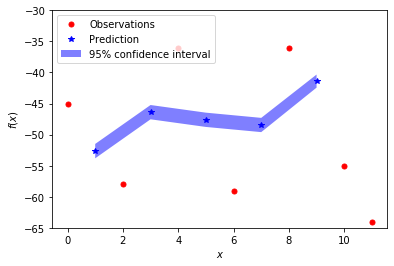

In [10]:
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X_test, mean, 'b*', label='Prediction')
plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([mean-1.960*sigma,
                        (mean+1.960*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-65, -30)
plt.legend(loc='upper left')